# **Avance 2. Series de tiempo univariadas:**
## **Universidad Nacional de Colombia.**
## **Docente:**

  - [Sergio Alejandro Calderón Villanueva](sacalderonv@unal.edu.co)

## **Autores:**

  - [Michel Mendivenson Barragán Zabala](mbarraganz@unal.edu.co)
  - [Sharon Juliana Zambrano Ortiz](shzambranoo@unal.edu.co)
  - [Nicolás Alejandro Quenguan Parra](naquenguanp@unal.edu.co)
  - [Aryin Jair Torres Quiñone](artorresq@unal.edu.co)

---
**Nota 1:** Los avances estaban siendo realizados en archivos de Rmarkdown `.Rmd`. Sin embargo, como la intención de este avance es incluir algunos modelos de aprendizaje profundo (Redes neuronales multicapa y redes recurrentes) con el fin de no utilizar recursos de computo de los equipos de cada uno de los autores se entregará el avance 2 como un archivo de jupyter notebook `.ipynb` que además de permitir el uso de computación en la nube para tareas pesadas usando Google Collab cuando los recursos de forma local sean reducidos también (Por ser `python`) permite construir chunks que usen código de `R` y `python` cuyos objetos tienen la posibilidad de interactuar entre sí (Veáse: [R and Python in one Jupyter notebook](https://stackoverflow.com/questions/39008069/r-and-python-in-one-jupyter-notebook))

**Nota 2:** Si se está editando este documento desde Google Collab, no es posible hacer `commit` directamente al repositorio. En cambio, hay que dar en la opción `File > Save a copy in GitHub`.

---

El siguiente código habilita el uso de código de `R` y `python` en simultáneo (Es neceasario el paquete `rpy2`):

In [1]:
%load_ext rpy2.ipython

Ahora se cargan los datos usando `R` y se exporta el objeto a `python`:

In [2]:
%%R -o leche
leche = read.csv("https://raw.githubusercontent.com/Mendivenson/Series-de-tiempo/main/Datos/Volumen%20de%20Acopio%20Total%20%20(2008%20-%202023).csv")
leche = leche[, c('Periodo', 'NACIONAL')]

Cualquier chunk de código que inicie con `%%R` será código `R` por lo que el siguiente código es 100% `python`:

In [3]:
leche

,Periodo,NACIONAL
1,Jan-08,2.458355e+08
2,Feb-08,2.130557e+08
3,Mar-08,2.175541e+08
4,Apr-08,2.224843e+08
5,May-08,2.386657e+08
...,...,...
188,Aug-23,2.979559e+08
189,Sep-23,2.845475e+08
190,Oct-23,2.876751e+08
191,Nov-23,2.809905e+08


En este avance se podrán encontrar tres cosas importantes para cada una de las series:

- Implementaciones de un filtro exponencial (`R`)
- Implementaciones de árboles de decisión binarios (`python`)
- Entrenamiento de redes neuronales multicapa (`python`)
- Entrenamiento de redes neuronales concurrentes (`python`)

# Filtro exponencial


# Árboles de decisión

Los árboles de decisión generalmente no son óptimos cuando se tienen series con tendencia por lo que es necesario eliminar la tendencia de las series antes de implementar cualquier árbol. Por lo realizado en el [Avance 1](https://rpubs.com/Mendivenson/Avance1_STdU) se decide usar el método de suavizamiento kernel para eliminar la tendencia de la serie del volumen de acopio de leche mensual y el filtro de * para la serie del oro:

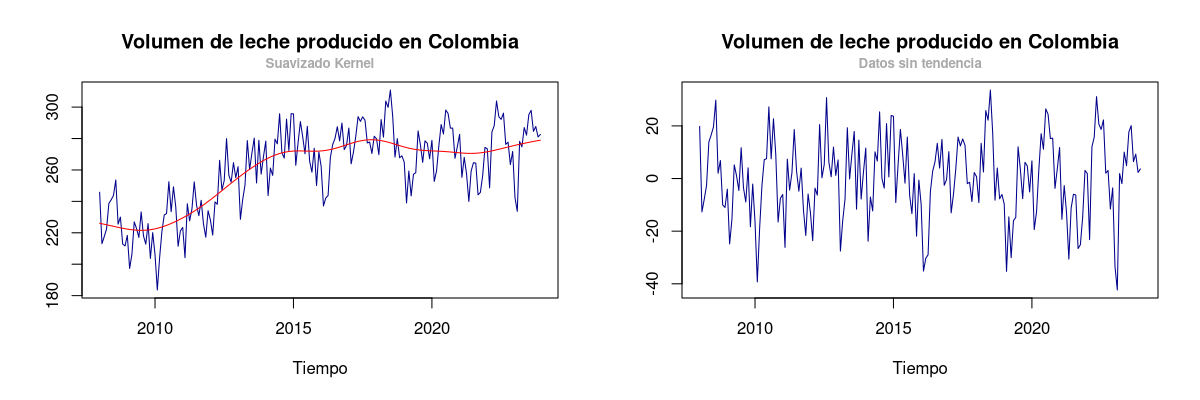

In [4]:
%%R -o leche -w 12 -h 4 --units in -r 100
leche$NACIONAL = leche$NACIONAL/1000000
# plot(leche$NACIONAL, type = 'l')
tiempo = seq(2008, 2023.95, by = 1/12)
predicciones = ksmooth(y = leche$NACIONAL, x = tiempo, kernel = 'normal', bandwidth = 2.5)$y
# leche$NACIONAL = leche$NACIONAL - predicciones$y
par(mfrow = c(1,2))

plot(x = tiempo ,y = leche$NACIONAL, xlab = 'Tiempo', ylab = '', 
        main = 'Volumen de leche producido en Colombia',
        col = 'darkblue', cex = 0.5, type = 'l')
mtext(bquote(bold('Suavizado Kernel')), side = 3, line = 0.5, 
      adj = 0.5, cex = 0.8, col = 'darkgray')
lines(x = tiempo,y = predicciones, col = 'red')

# Datos sin tendencia
plot(x = tiempo,y = leche$NACIONAL - predicciones,xlab = 'Tiempo', ylab = '', main = 'Volumen de leche producido en Colombia',
     col = 'darkblue', cex = 0.5, type = 'l')
mtext(bquote(bold('Datos sin tendencia')), side = 3, line = 0.5, adj = 0.5, cex = 0.8, col = 'darkgray')

leche$NACIONAL = leche$NACIONAL - predicciones

In [5]:
leche

,Periodo,NACIONAL
1,Jan-08,19.795864
2,Feb-08,-12.682066
3,Mar-08,-7.872412
4,Apr-08,-2.623688
5,May-08,13.881874
...,...,...
188,Aug-23,20.100389
189,Sep-23,6.408911
190,Oct-23,9.259564
191,Nov-23,2.303314


Ahora con los datos sin tendencia, implementamos nuestro árbol de decisión:

In [6]:
type(leche)

pandas.core.frame.DataFrame